# Actor-Critic method to interact with Halfcheetah environment

Actor-Critic methods are an hybrid architecture combining value-based and Policy-Based methods that helps to stabilize the training by reducing the variance using:

* An Actor that controls how our agent behaves (Policy-Based method)
* A Critic that measures how good the taken action is (Value-Based method)

## Advantage Actor-Critic (A2C)

Base idea in Actor-Critic methods is to have an Actor (the agent) that takes actions, based on those action the Critic provide a feedback. On the other way Critic updates its way to provide feedback during the process.

As we saw, with Actor-Critic methods, there are two function approximations (two neural networks):

* **Actor**, a policy function parameterized by theta:
𝜋
𝜃
(
𝑠
)
π
θ
​
 (s)
* **Critic**, a value function parameterized by w:
𝑞
^
𝑤
(
𝑠
,
𝑎
)

The training process works as follow:

* At each timestep, t, we get the current state
𝑆
𝑡
​
   from the environment and pass it as input through our Actor and Critic.
* Our Policy takes the state and outputs an action
𝐴
𝑡
​
 .

* The Critic takes that action also as input and, using
𝑆
𝑡
S
t
​
  and
𝐴
𝑡
A
t
​
 , computes the value of taking that action at that state: the Q-value.
* The action
𝐴
𝑡
A
t
​
  performed in the environment outputs a new state
𝑆
𝑡
+
1
S
t+1
​
  and a reward
𝑅
𝑡
+
1
R
t+1
​
  .
* The Actor updates its policy parameters using the Q value.
* Thanks to its updated parameters, the Actor produces the next action to take at
𝐴
𝑡
+
1
A
t+1
​
  given the new state
𝑆
𝑡
+
1
S
t+1
​
 .
* The Critic then updates its value parameters.

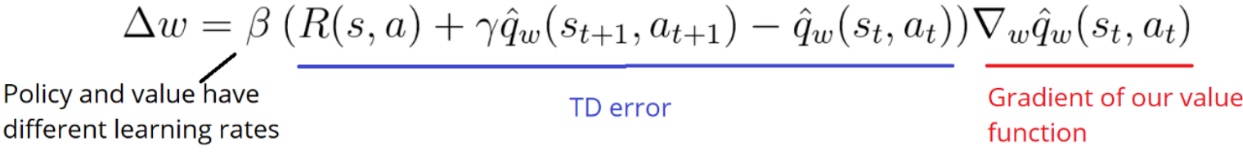

## Adding Advantage in Actor-Critic (A2C)
We can stabilize learning further by using the Advantage function as Critic instead of the Action value function.

The idea is that the Advantage function calculates the relative advantage of an action compared to the others possible at a state: how taking that action at a state is better compared to the average value of the state. It’s subtracting the mean value of the state from the state action pair:

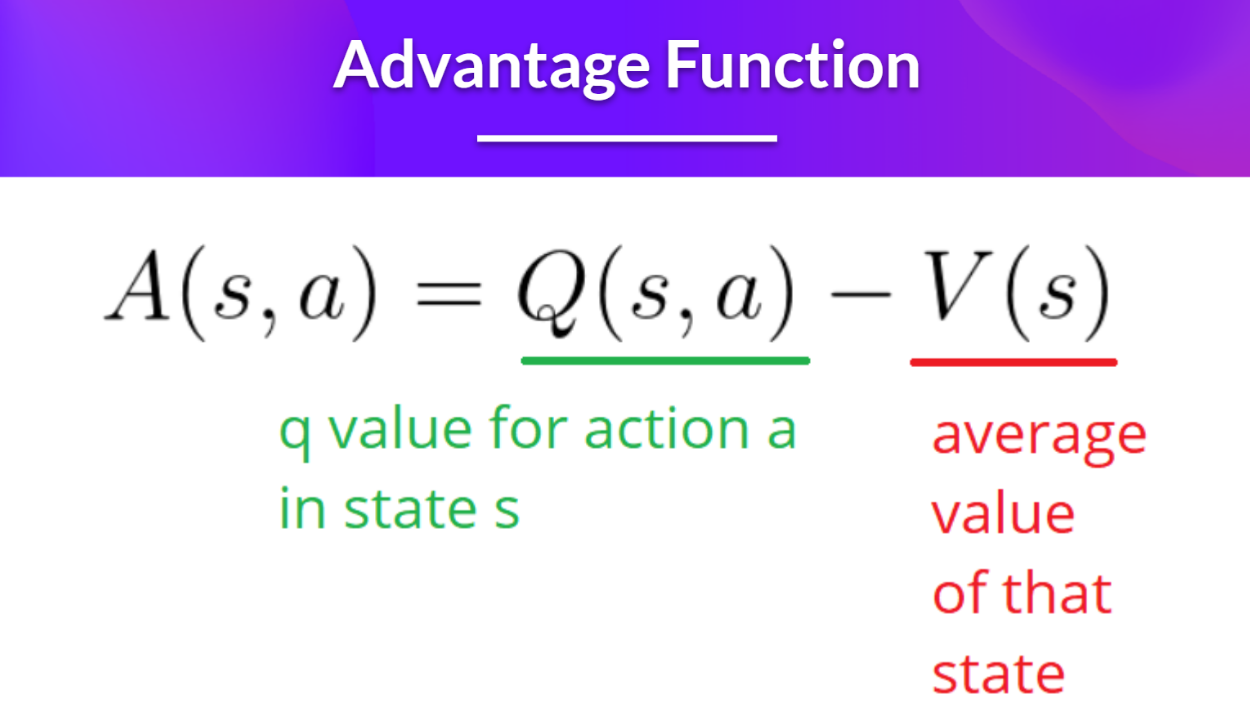

In other words, this function calculates the extra reward we get if we take this action at that state compared to the mean reward we get at that state.

The extra reward is what’s beyond the expected value of that state.

* If A(s,a) > 0: our gradient is pushed in that direction.
* If A(s,a) < 0 (our action does worse than the average value of that state), our gradient is pushed in the opposite direction.
The problem with implementing this advantage function is that it requires two value functions —
𝑄
(
𝑠
,
𝑎
)
Q(s,a) and
𝑉
(
𝑠
)
V(s). Fortunately, we can use the TD error as a good estimator of the advantage function.

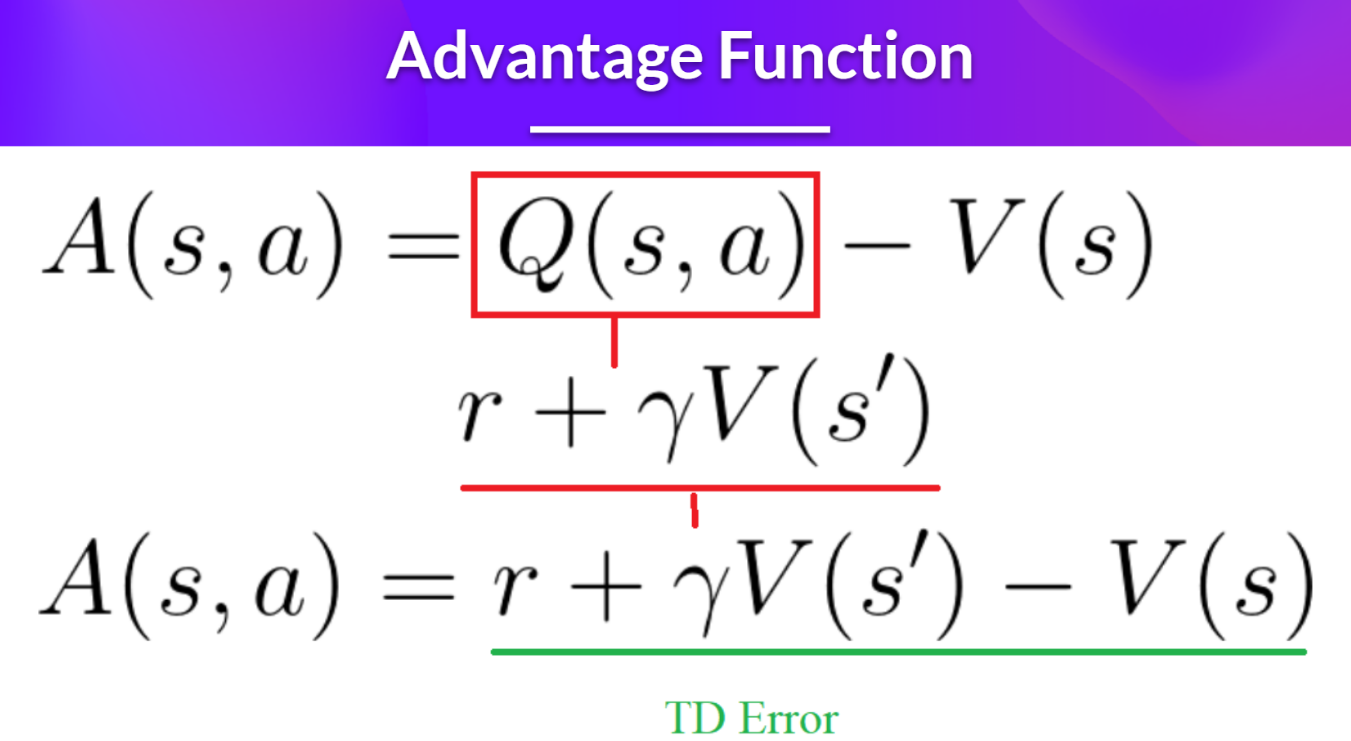

# Dive into implementation

We install first some utilities:
* libgl1-mesa-dev: Development files for Mesa OpenGL library
*  libgl1-mesa-glx: Runtime libraries for Mesa OpenGL
*  libglew-dev: Development files for OpenGL Extension Wrangler Library
*  libosmesa6-dev: Development files for off-screen Mesa rendering
*  software-properties-common: Tools for managing software repositories
*  patchelf: Utility to modify ELF executables
*  xvfb: X Virtual Framebuffer for running graphical applications without a display
*  python-opengl: Python bindings for OpenGL
*  ffmpeg: Multimedia framework for handling video and audio
*  gym (via pip): OpenAI Gym toolkit for developing reinforcement learning algorithms
*  pyvirtualdisplay (via pip): Python wrapper for Xvfb, Xephyr and Xvnc

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    patchelf \
    xvfb \
    python-opengl \
    ffmpeg > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

### Install dependencies

In [ ]:
# Uninstall conflicting packages
!pip uninstall -y dopamine-rl gym

# Install HuggingFace utilities and display utilities
!pip install IPython
!pip install stable-baselines3[extra]
!pip install huggingface_sb3

# Install a compatible version of gym
!pip install gym==0.25.2

# Reinstall dopamine-rl
!pip install dopamine-rl

# Install free-mujoco-py and related packages
!pip install free-mujoco-py
!pip install mujoco
!pip install gym[mujoco]

# Install transformers with torch support
!pip install transformers[torch]

# Install and upgrade accelerate
!pip install accelerate -U

# Install datasets with compatible versions
!pip install datasets==2.14.5

# Install specific versions of imageio and imageio-ffmpeg
!pip install imageio==2.9.0
!pip install imageio-ffmpeg==0.4.5

# Install colabgymrender
!pip install colabgymrender==1.0.2

# Install xvfbwrapper
!pip install xvfbwrapper

# Install compatible versions of pyarrow and requests
!pip install pyarrow==14.0.2
!pip install requests==2.31.0

## Import the packages

In [ ]:
!sudo apt-get update
!sudo apt-get install -y gcc g++ make libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [ ]:
import os

import mujoco_py
import gym

from huggingface_sb3 import load_from_hub, package_to_hub

from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from colabgymrender.recorder import Recorder

## HalfCheetah-V3 environment



**What is it?**
This environment is based on the work by P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply a torque on the joints to make the cheetah run forward (right) as fast as possible, with a positive reward allocated based on the distance moved forward and a negative reward allocated for moving backward. The torso and head of the cheetah are fixed, and the torque can only be applied on the other 6 joints over the front and back thighs (connecting to the torso), shins (connecting to the thighs) and feet (connecting to the shins).
**Aim**
The primary goal is to train an agent to control the cheetah to run forward as fast as possible while maintaining efficiency.

**How it works**

*State Space*

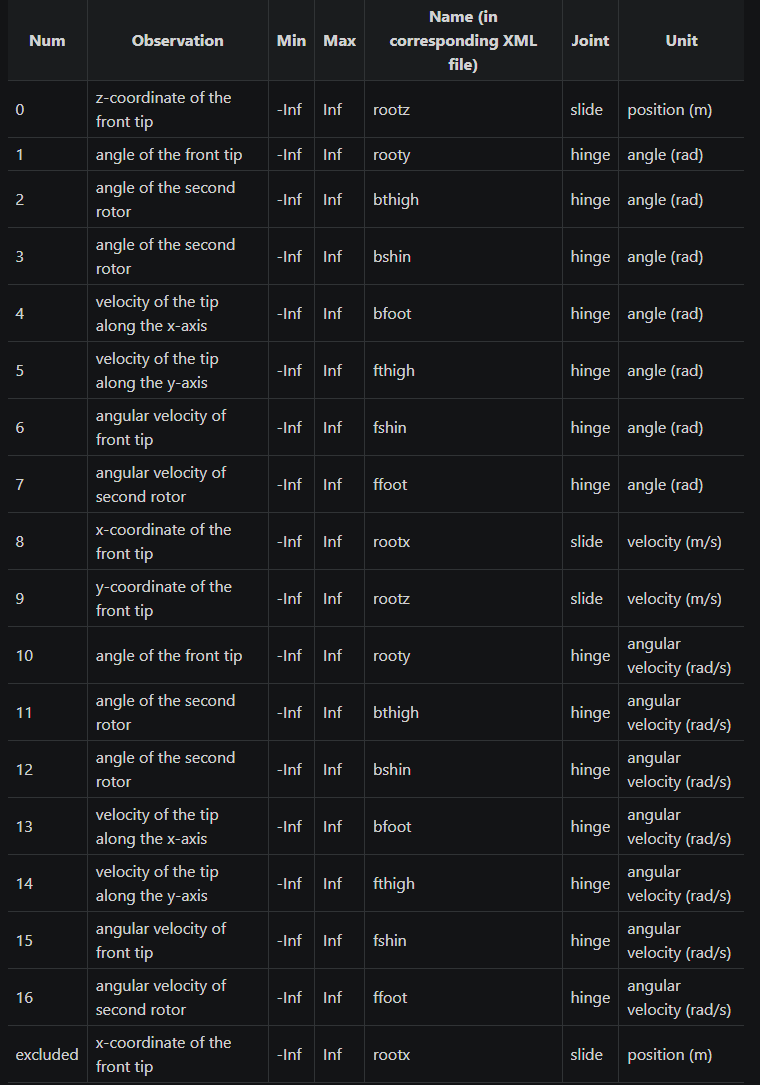

*Action Space*

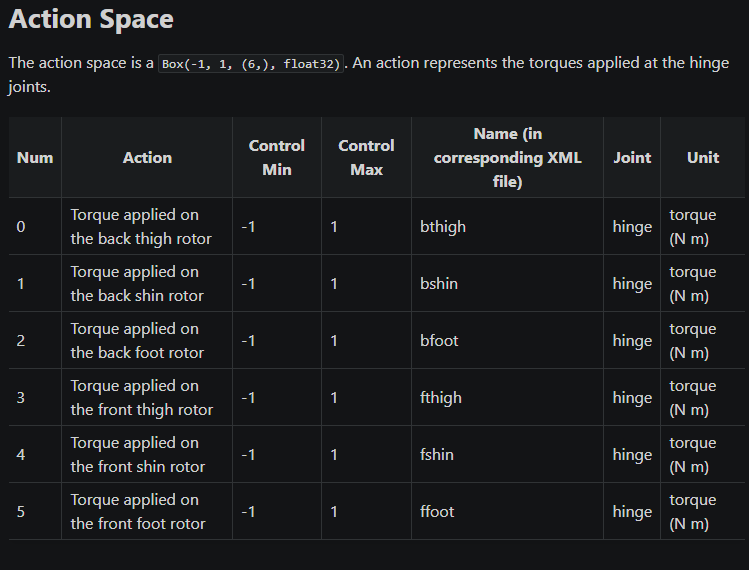

### Create the environment

In [ ]:
env_id = "HalfCheetah-v3"

# Create the env
env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape
a_size = env.action_space

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

Observations consist of positional values of different body parts of the cheetah, followed by the velocities of those individual parts (their derivatives) with all the positions ordered before all the velocities.

By default, observations do not include the cheetah’s `rootx`. It may be included by passing `exclude_current_positions_from_observation=False` during construction. In that case, the observation space will be a `Box(-Inf, Inf, (18,), float64)` where the first element represents the rootx. Regardless of whether `exclude_current_positions_from_observation` was set to true or false, the will be returned in `info` with key `"x_position"`.

However, by default, the observation is a `Box(-Inf, Inf, (17,), float64)` where the elements correspond to the following:

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The action space is a `Box(-1, 1, (6,), float32)`. An action represents the torques applied at the hinge joints.

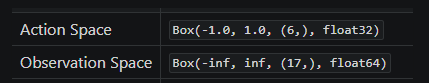

## Vectorized Environments
[Vectorized Environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html) are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).



### Normalize observation and rewards

A good practice in reinforcement learning is to [normalize input features](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html).

For that purpose, there is a wrapper that will compute a running average and standard deviation of input features.

We also normalize rewards with this same wrapper by adding `norm_reward = True`.

In [ ]:
env = make_vec_env(env_id, n_envs=4)

# Adding this wrapper to normalize the observation and the reward
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

### Create the A2C Model
To create the model i've chosen to adopt a Stable-Baseline3 implementation of A2C policies, simple and elegant.
To find the best parameters I checked the [official trained agents by Stable-Baselines3 team](https://huggingface.co/sb3).

In [ ]:
model = A2C(policy="MlpPolicy",
            env=env,
            verbose=1)

MlpPolicy stands for Multi-layer Perceptron Policy. As said in as introduction it consists of a neural network architecture used for both the actor and the critic in the A2C algorithm:

* The actor network outputs action probabilities for discrete action spaces or action values for continuous action spaces.
* The critic network estimates the value function, which predicts the expected return from the current state.

In following cells a detailed view on the policy and the parameters.

In [ ]:
model.policy

**Model Architecture**

*Input Layer:*

* Takes as input, 17 features our state space.

*Feature Extraction:*

* Uses a FlattenExtractor for both policy and value networks.
Flattens the input from any dimensional tensor to a 1D tensor.


***Policy Network (Actor):***

It is a Two-layer MLP (Multi-Layer Perceptron):

* First layer: 17 → 64 neurons, with Tanh activation
* Second layer: 64 → 64 neurons, with Tanh activation
* Output layer: 64 → 6 neurons (representing 6 possible actions)


***Value Network (Critic):***

Two-layer MLP:

* First layer: 17 → 64 neurons, with Tanh activation
* Second layer: 64 → 64 neurons, with Tanh activation
* Output layer: 64 → 1 neuron (representing the state value)




In [ ]:
parameters = vars(model)

for key, value in parameters.items():
    print(f"{key}: {value}")

And here we can see some of most important parameters.

### Train the A2C agent
- Let's train our agent for 3,000,000 timesteps, to train my model i've used Google Colab with GPU backend. It will take approximately ~25-40min.

We define some callbacks, saving our agents during training.

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback

# Define the callback
checkpoint_callback = CheckpointCallback(
    save_freq=100000,  # Save every 100,000 steps
    save_path="./logs/",
    name_prefix="cheetah_agent",
    save_replay_buffer=True,
    save_vecnormalize=True
)

In [ ]:
model.learn(3_000_000, callback=checkpoint_callback)

In [ ]:
# Save the model and  VecNormalize statistics when saving the agent
model.save("a2c-Cheetah-v3")
env.save("vec_normalize.pkl")

### Evaluate the agent
- Now that's our  agent is trained, we need to **check its performance**.
- Stable-Baselines3 provides a method to do that: `evaluate_policy`

In [ ]:
from stable_baselines3.common.env_util import make_vec_env

# Instead of creating the environment directly, use make_vec_env
eval_env = make_vec_env("HalfCheetah-v3", n_envs=1, wrapper_class=lambda env: env)
eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)

# We need to override the render_mode
eval_env.render_mode = "rgb_array"

#  do not update them at test time
eval_env.training = False
# reward normalization is not needed at test time
eval_env.norm_reward = False

# Load the agent
model = A2C.load("a2c-Cheetah-v3")

mean_reward, std_reward = evaluate_policy(model, eval_env)

print(f"Mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")

### Show how agent interact with environment

In [ ]:
!apt-get update
!apt-get install -y xvfb

In [ ]:
!pip install pyvirtualdisplay

In [ ]:
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import gym
from stable_baselines3 import A2C
import numpy as np
from gym import wrappers
from xvfbwrapper import Xvfb

# Start virtual framebuffer
vdisplay = Xvfb()
vdisplay.start()

try:
    # Load the trained model
    model = A2C.load("a2c-Cheetah-v3")

    # Create the environment
    env = gym.make('HalfCheetah-v3', render_mode='rgb_array')

    # Wrap the environment with a video recorder
    env = wrappers.RecordVideo(env, "videos", episode_trigger=lambda x: True)

    # Reset the environment
    obs = env.reset()

    # Run for a certain number of steps
    for _ in range(1000):
        # Get the model's action
        action, _states = model.predict(obs, deterministic=True)

        # Take the action in the environment
        obs, reward, done, info = env.step(action)

        # No need to call env.render() explicitly, RecordVideo wrapper handles it

        if done:
            obs = env.reset()

    # Close the environment
    env.close()

finally:
    # Stop virtual framebuffer
    vdisplay.stop()

In [ ]:
from IPython.display import Video

video_path = 'videos/rl-video-episode-0.mp4'
Video(video_path, embed=True)

In [ ]:
!pip freeze > a2c_requirements.txt

Downloading logs, models and videos.

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('/content/logs_backup_a2c', 'zip', '/content/logs')
files.download('/content/logs_backup_a2c.zip')

shutil.make_archive('/content/saved_models_a2c', 'zip', '/content/saved_models')
files.download('/content/saved_models_a2c.zip')

shutil.make_archive('/content/videos_a2c', 'zip', '/content/videos')
files.download('/content/videos_a2c.zip')

files.download('/content/a2c-Cheetah-v3.zip')
files.download('/content/vec_normalize.pkl')
files.download('/content/a2c_requirements.txt')